In [2]:
import wfdb
import numpy as np
import os

In [3]:
# Path to the folder containing the records
folder_path = 'C:\\Users\\jacob\\Desktop\\GitHub\\CS593-ProjectFiles\\Project 3\\ECG Anomoly Detection\\Dataset'

# List of record names
records = [f[:-4] for f in os.listdir(folder_path) if f.endswith('.dat')]

# Initialize empty lists to store the data
data = []
labels = []

# Window size
window_size = 3600

# Loop over all records
for record_name in records:
    try:
        # Load the record and the annotations
        record = wfdb.rdrecord(os.path.join(folder_path, record_name))
        annotation = wfdb.rdann(os.path.join(folder_path, record_name), 'atr')

        # Pad the signal data with zeros until its length is a multiple of the window size
        padded_length = np.ceil(record.p_signal.shape[0] / window_size) * window_size
        padded_signal = np.pad(record.p_signal, ((0, int(padded_length - record.p_signal.shape[0])), (0, 0)))

        # Reshape the padded signal data into windows
        X = np.reshape(padded_signal, (-1, window_size, 2))

        # Create labels for each window based on the annotations
        Y = np.zeros(X.shape[0])
        for i in range(len(annotation.sample)):
            if annotation.symbol[i] != 'N':
                Y[annotation.sample[i] // window_size] = 1

        # Append the data and the labels to the lists
        data.append(X)
        labels.append(Y)
    except:
        print(f"Error loading record {record_name}")

# Concatenate all the data and labels
data = np.concatenate(data)
labels = np.concatenate(labels)

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Preprocessing - Feature Extraction
# Calculate statistical features (mean and standard deviation) for each window
features = np.array([np.mean(window, axis=0) for window in data])
features = np.hstack((features, np.array([np.std(window, axis=0) for window in data])))
# Standardize the features to have 0 mean and unit variance
scaler = StandardScaler()
features = scaler.fit_transform(features)
# Create an Isolation Forest model
clf = IsolationForest(contamination=0.01)

# Fit the model on the features
clf.fit(features)

# Predict the anomalies in the data
pred = clf.predict(features)
# Check the anomaly score of each window
score = clf.decision_function(features)
anomalies = np.argwhere(pred == -1)

# Compare anomalies detected by the model with actual labels
for i in anomalies:
    print(f"Window {i}: Detected anomaly, Actual label: {'Anomaly' if labels[i] == 1 else 'Normal'}")
    

Window [658]: Detected anomaly, Actual label: Normal
Window [659]: Detected anomaly, Actual label: Anomaly
Window [660]: Detected anomaly, Actual label: Normal
Window [661]: Detected anomaly, Actual label: Normal
Window [662]: Detected anomaly, Actual label: Normal
Window [677]: Detected anomaly, Actual label: Normal
Window [678]: Detected anomaly, Actual label: Normal
Window [679]: Detected anomaly, Actual label: Anomaly
Window [680]: Detected anomaly, Actual label: Normal
Window [682]: Detected anomaly, Actual label: Normal
Window [1025]: Detected anomaly, Actual label: Anomaly
Window [1026]: Detected anomaly, Actual label: Normal
Window [1036]: Detected anomaly, Actual label: Anomaly
Window [1391]: Detected anomaly, Actual label: Anomaly
Window [1435]: Detected anomaly, Actual label: Anomaly
Window [1437]: Detected anomaly, Actual label: Anomaly
Window [1541]: Detected anomaly, Actual label: Anomaly
Window [1550]: Detected anomaly, Actual label: Normal
Window [1620]: Detected anomal

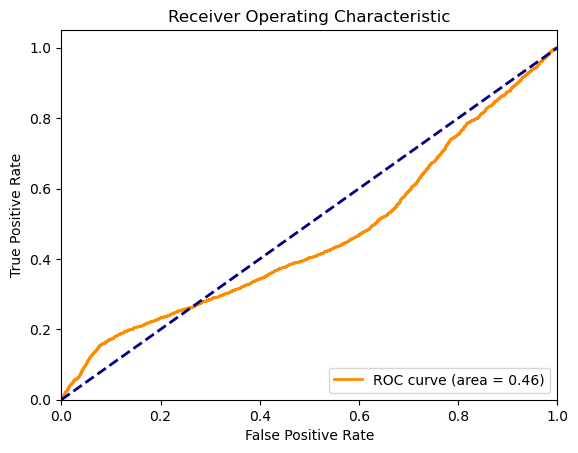

In [17]:
from sklearn.metrics import roc_curve, auc

# Get the anomaly scores
scores = clf.decision_function(features)

# Since in Isolation Forest, inliers (normal) have higher scores, we negate the scores for using with roc_curve
fpr, tpr, thresholds = roc_curve(labels, -scores)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

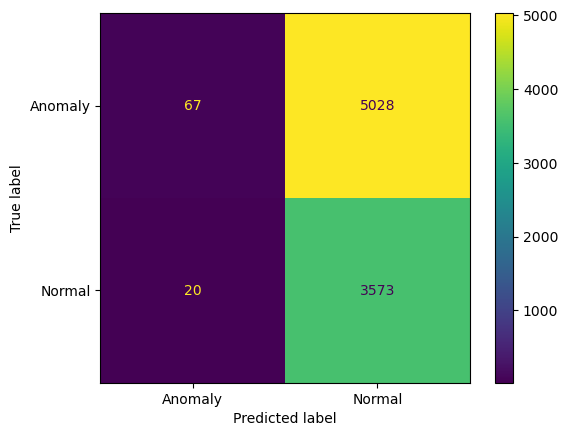

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# convert labels to match the prediction output of Isolation Forest
true_labels = np.where(labels == 1, -1, 1)

cm = confusion_matrix(true_labels, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
disp.plot()


# Anomaly Markings on ECG Signal

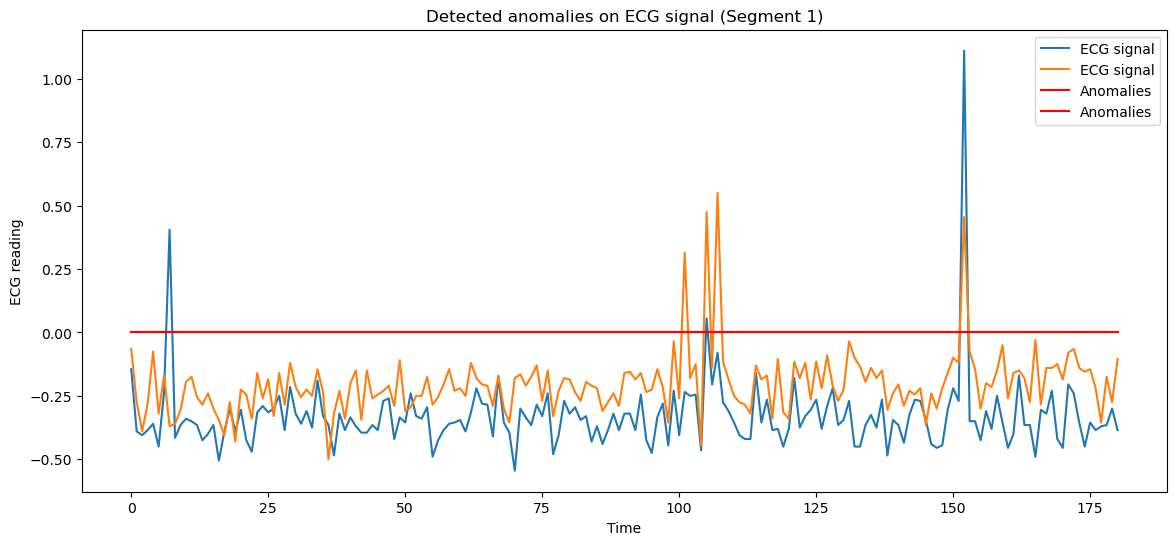

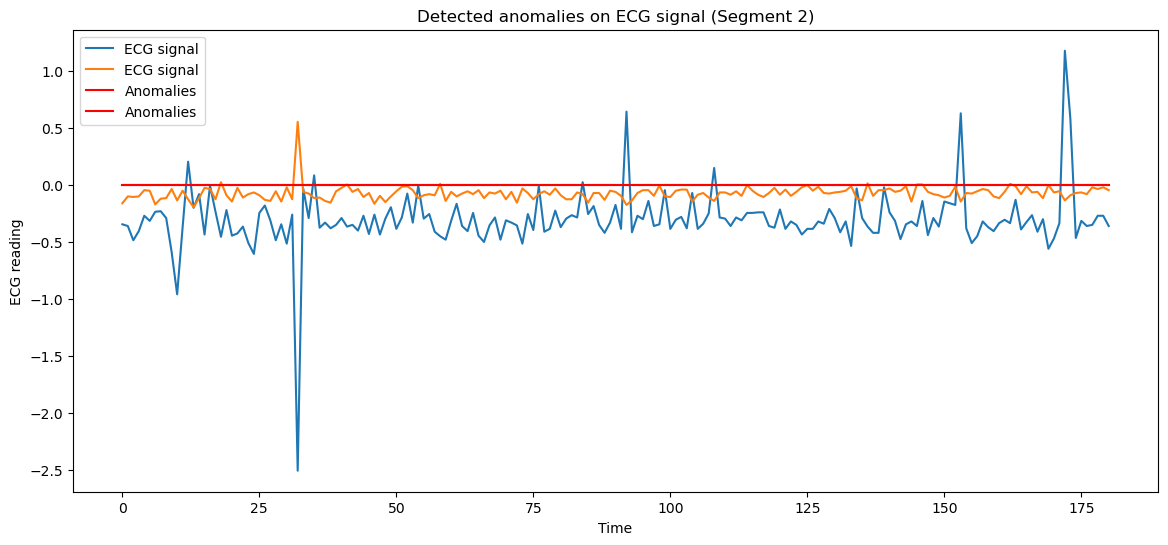

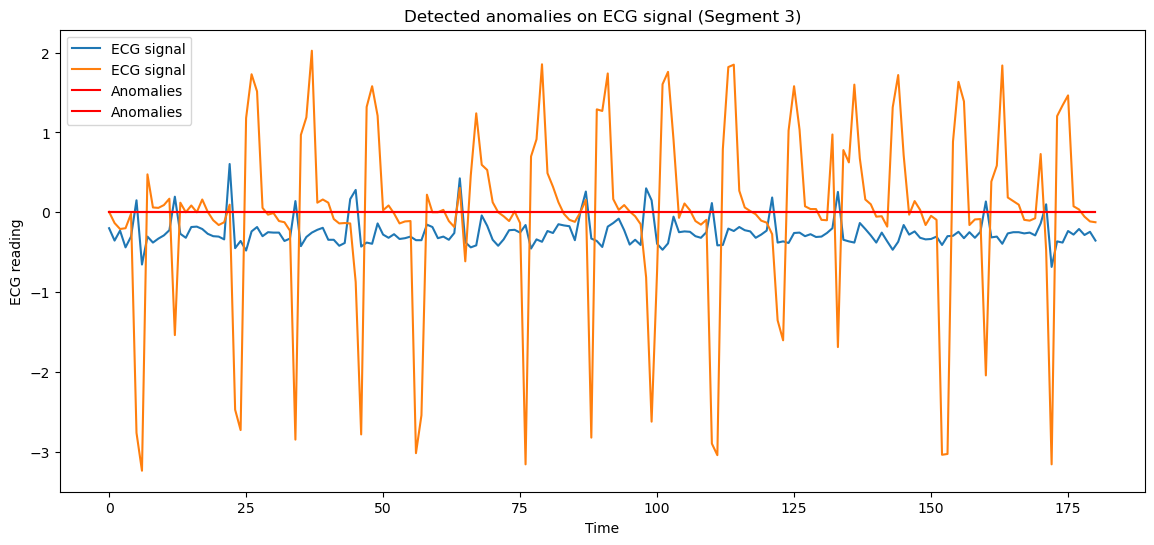

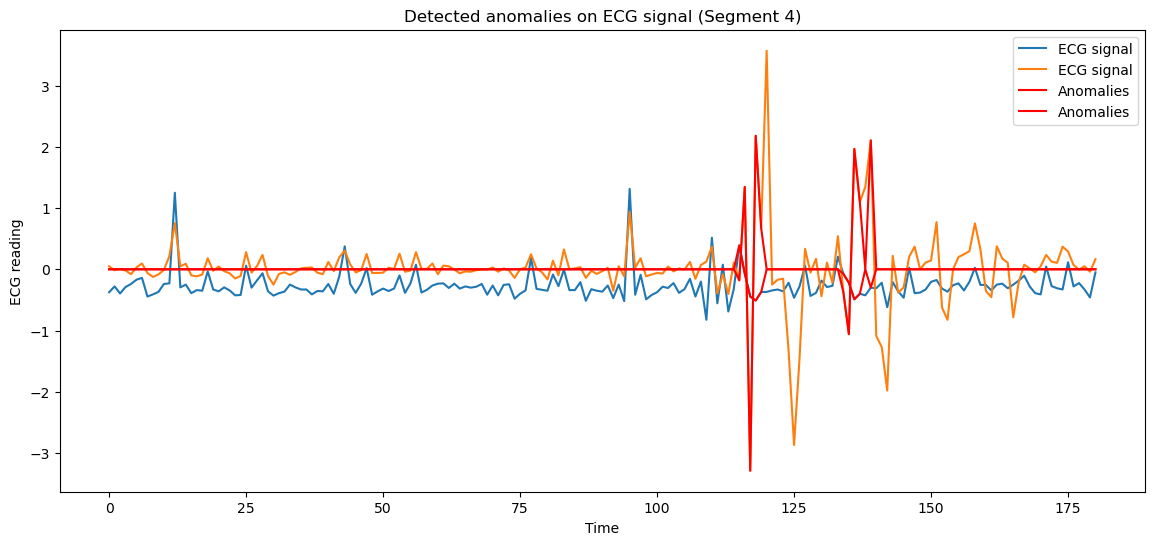

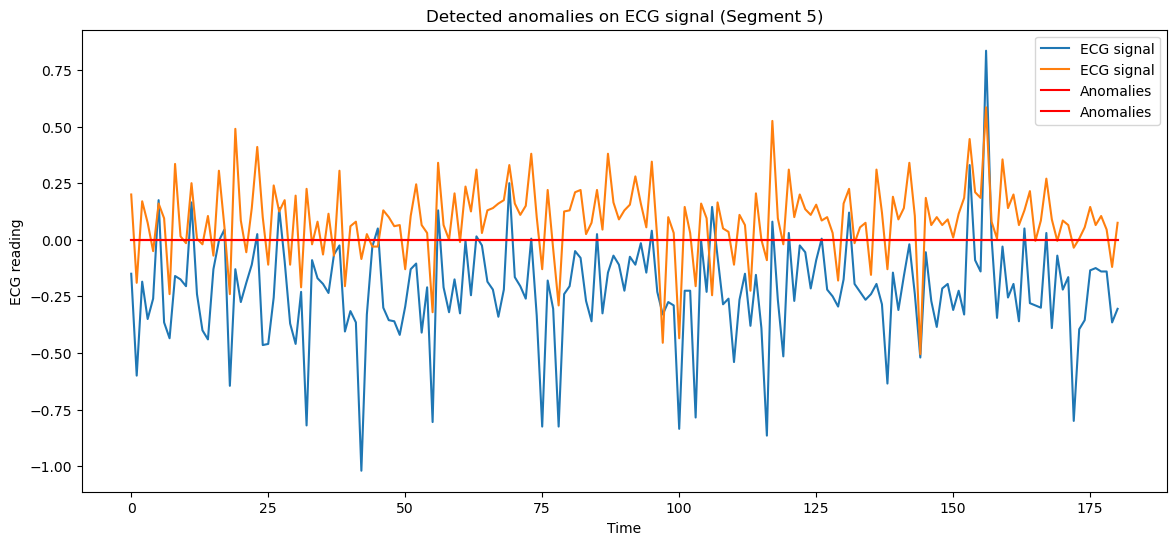

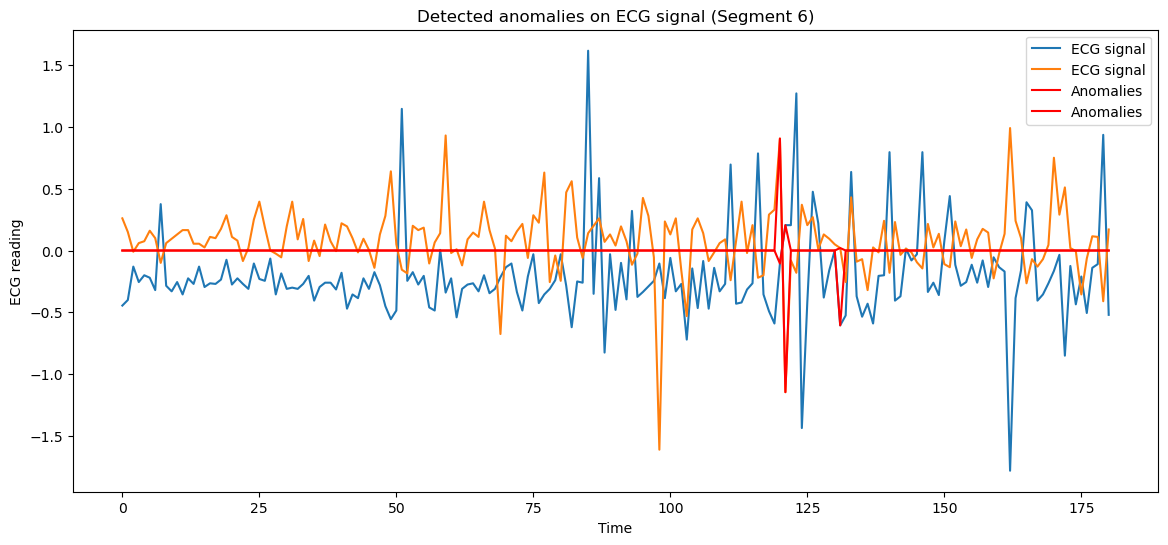

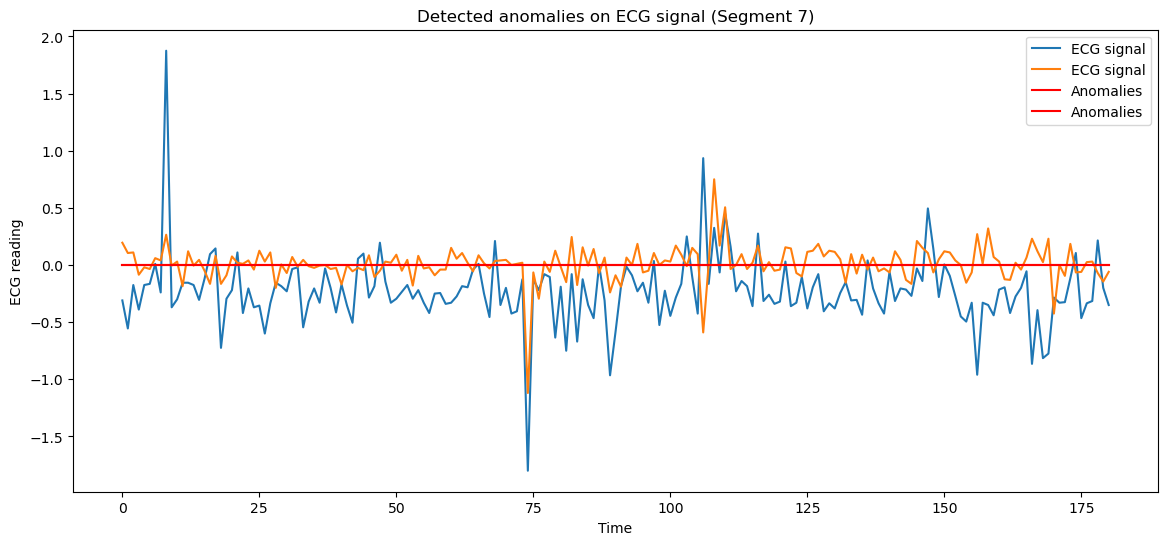

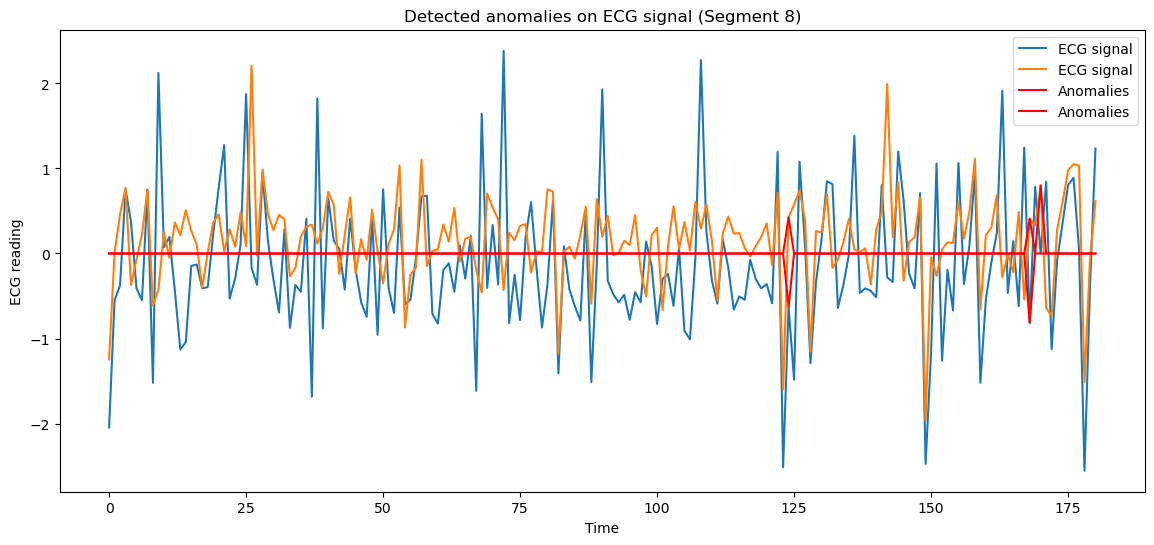

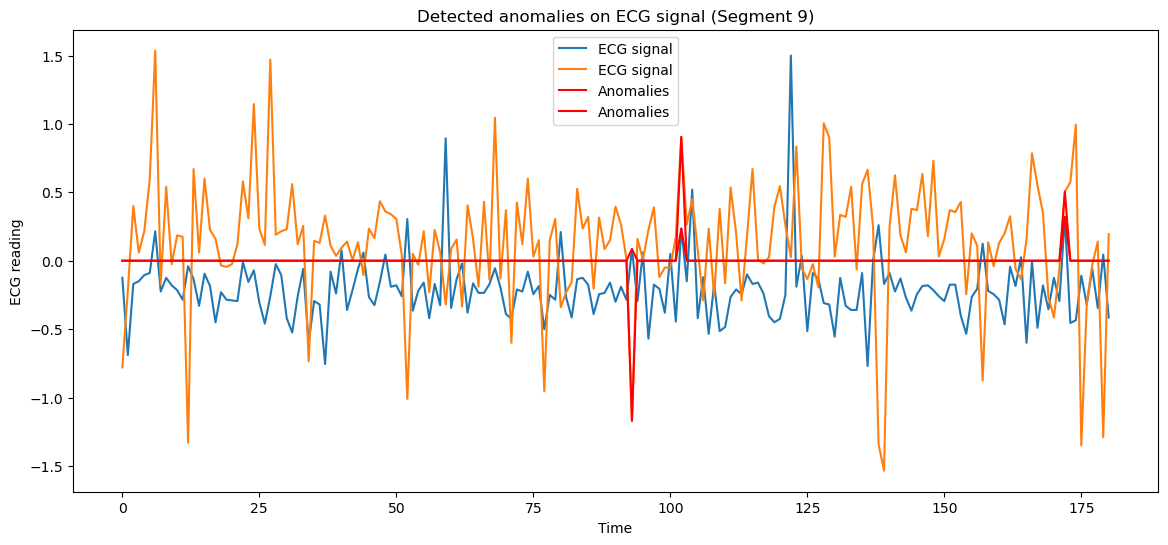

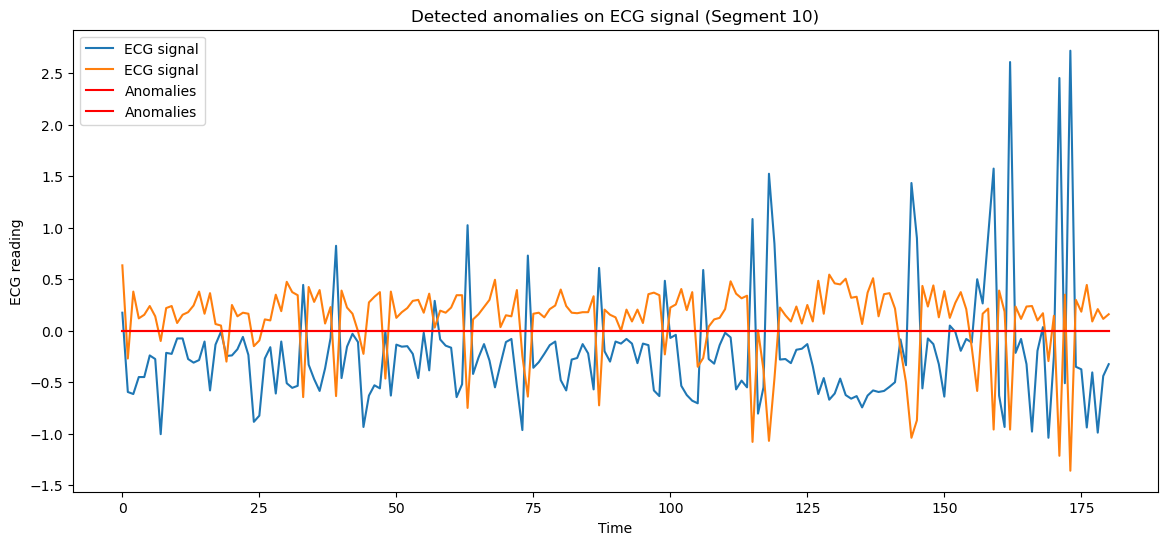

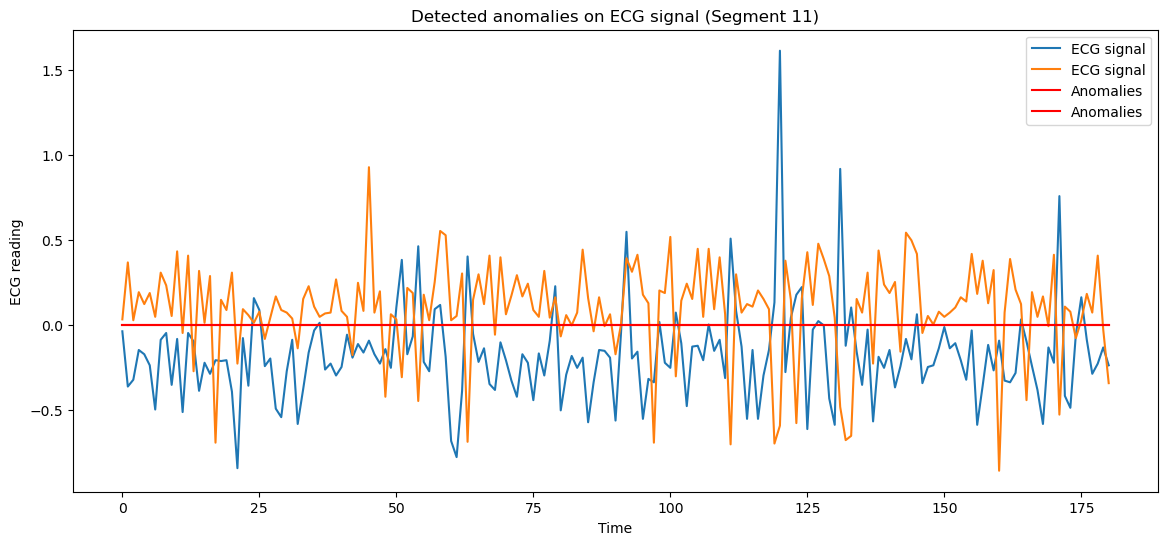

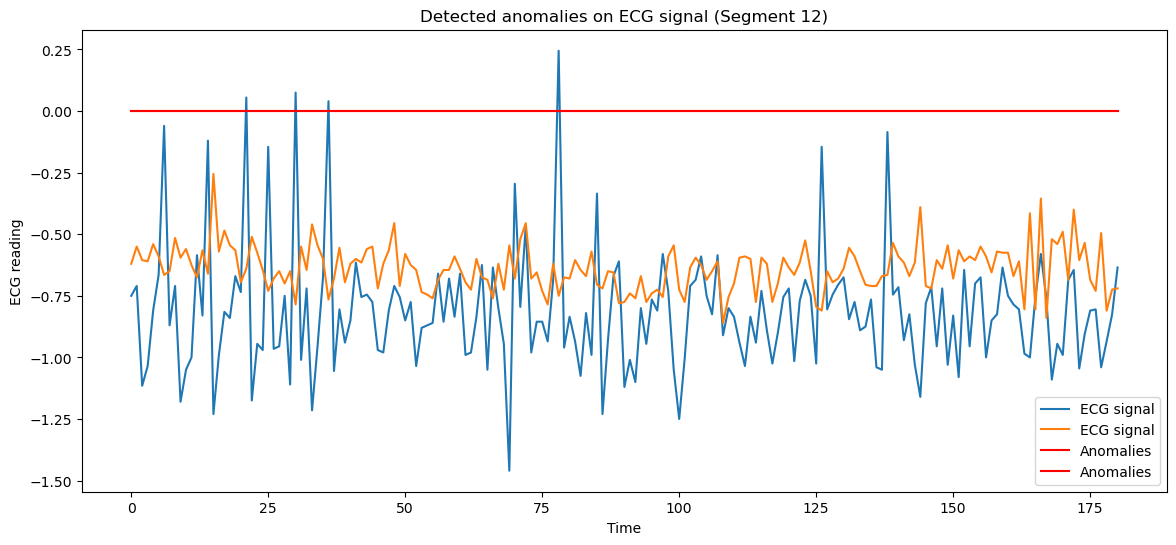

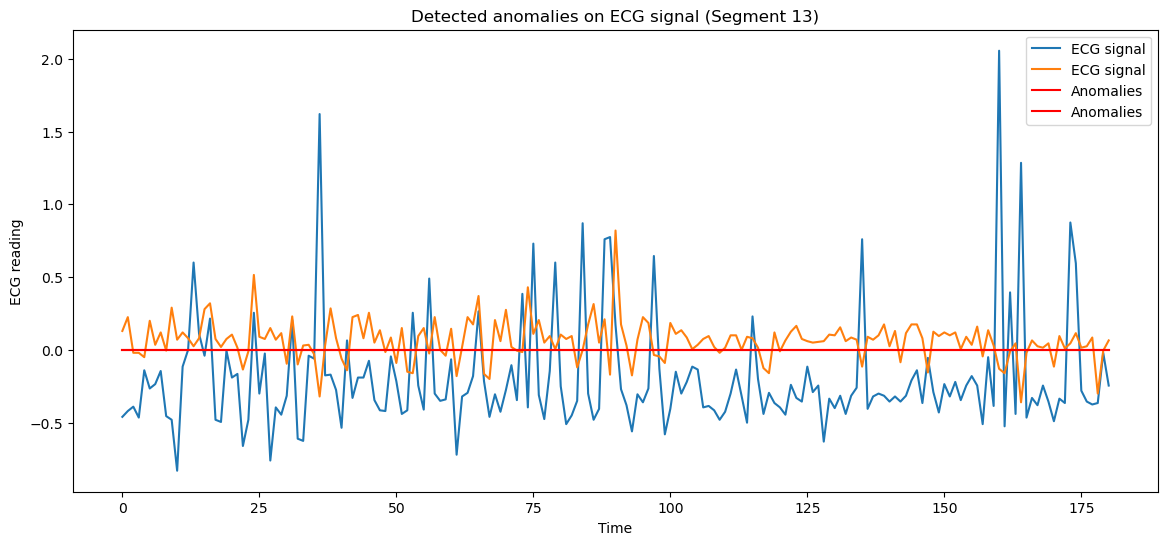

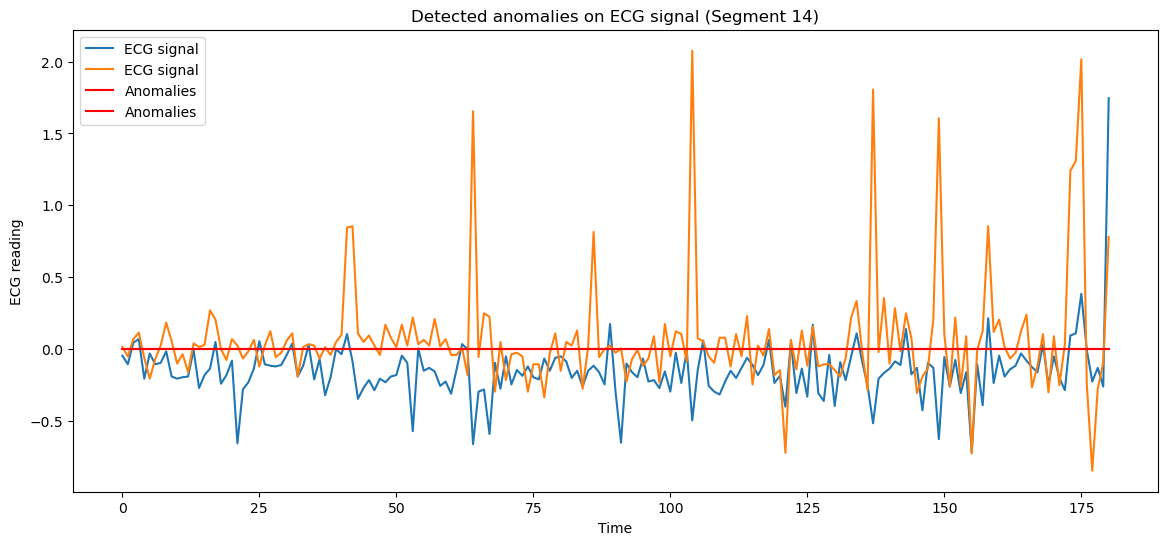

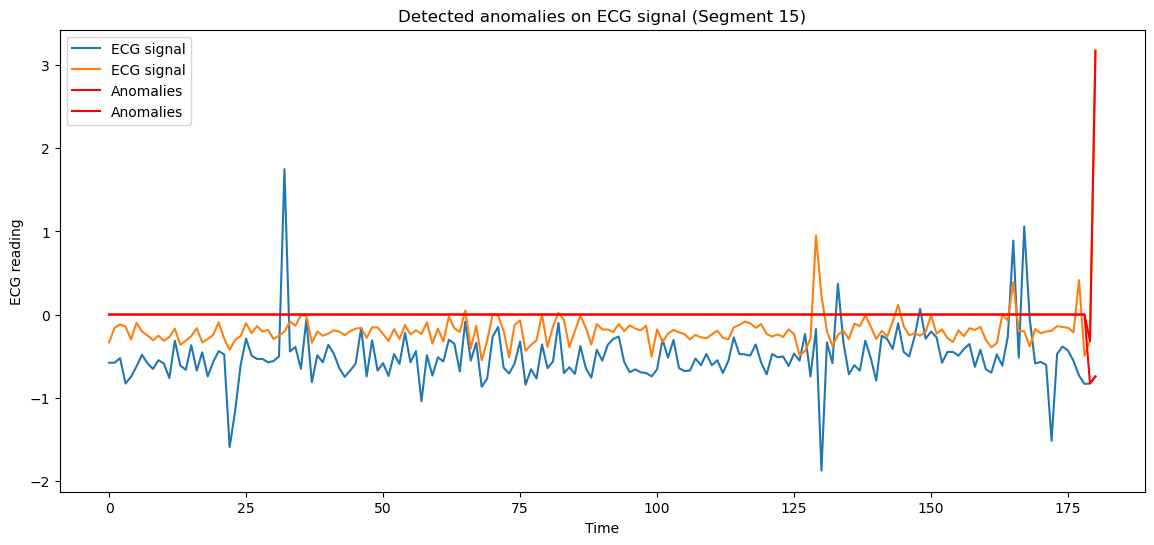

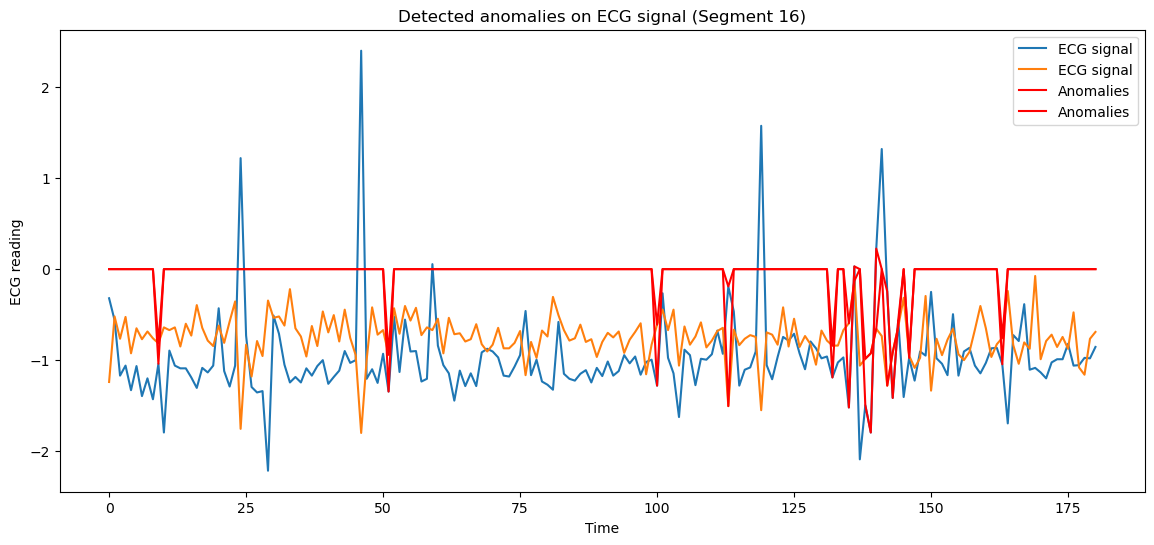

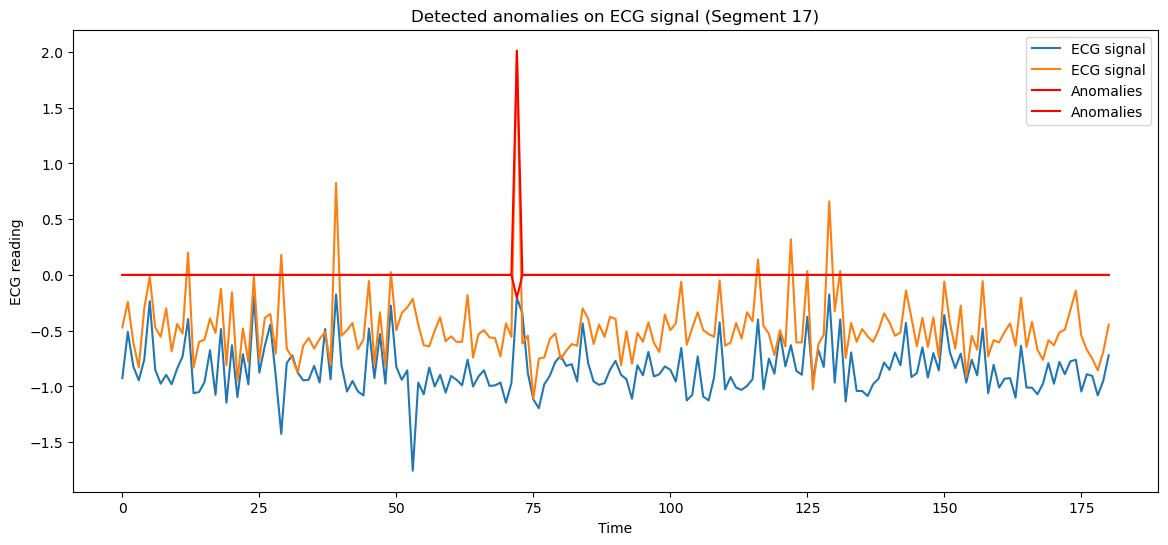

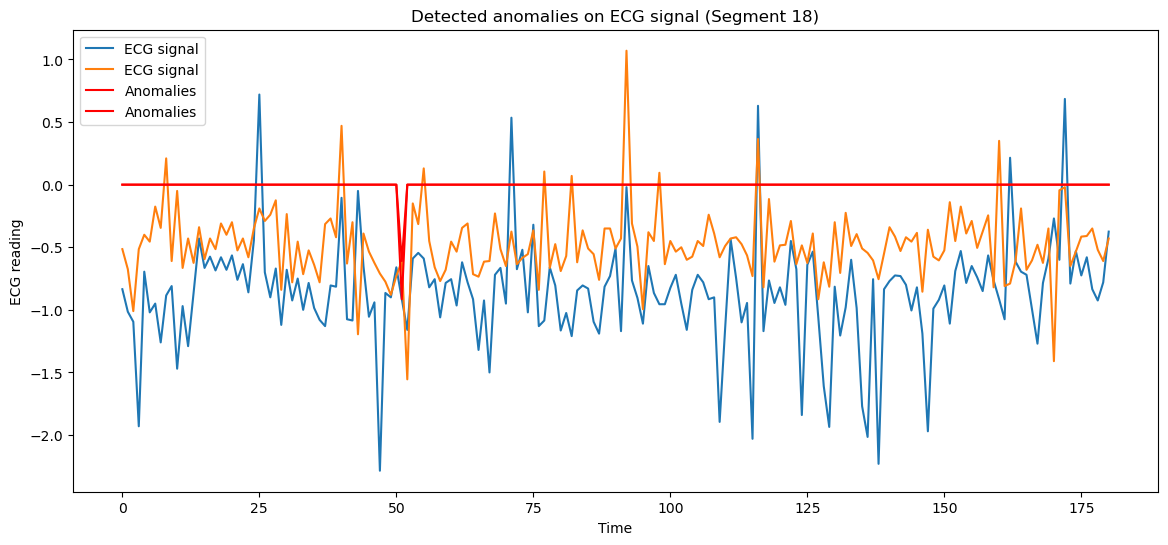

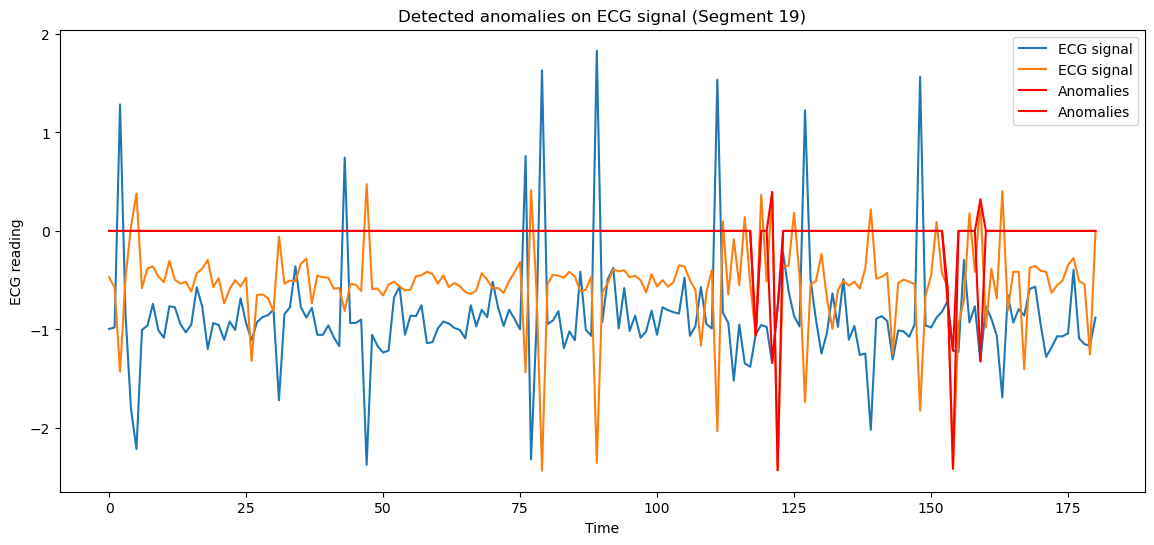

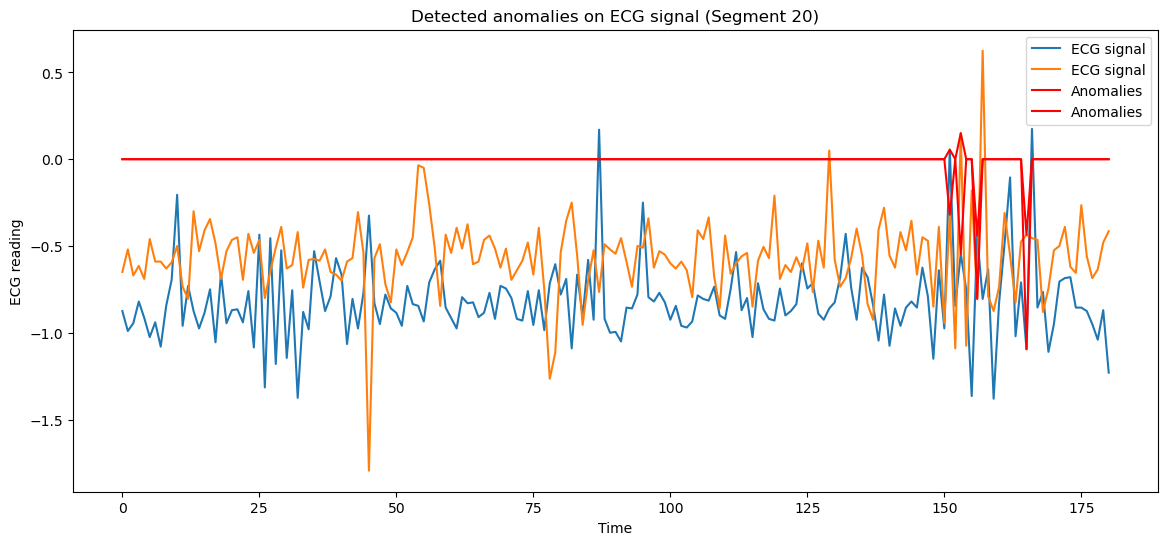

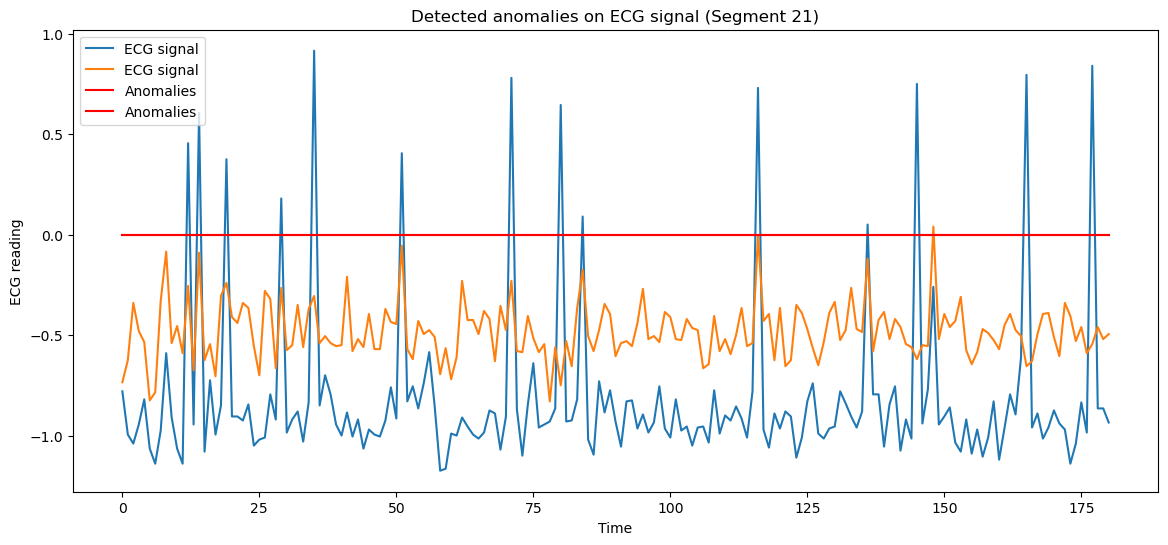

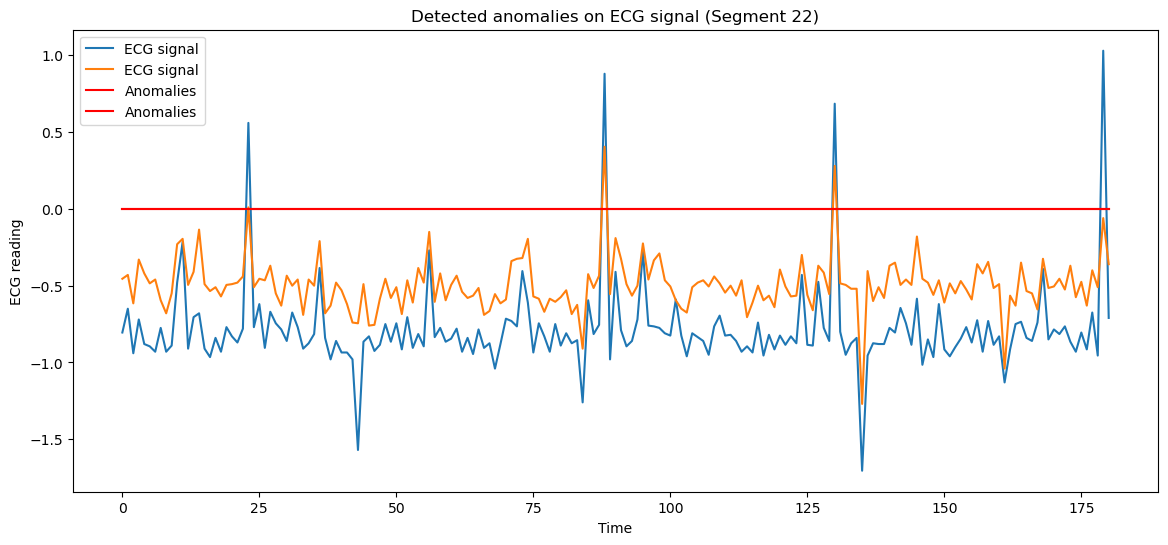

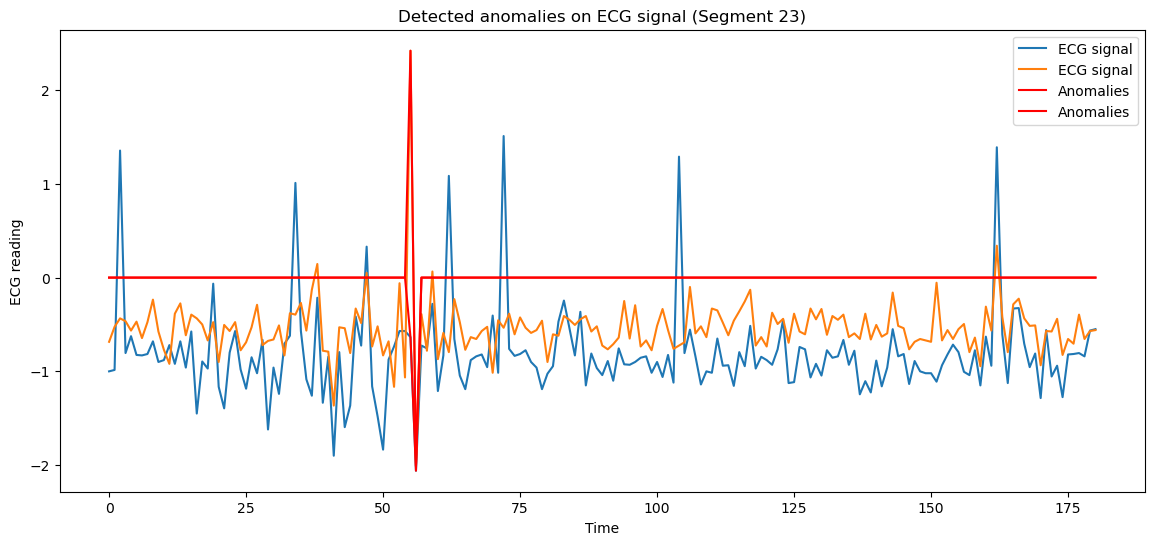

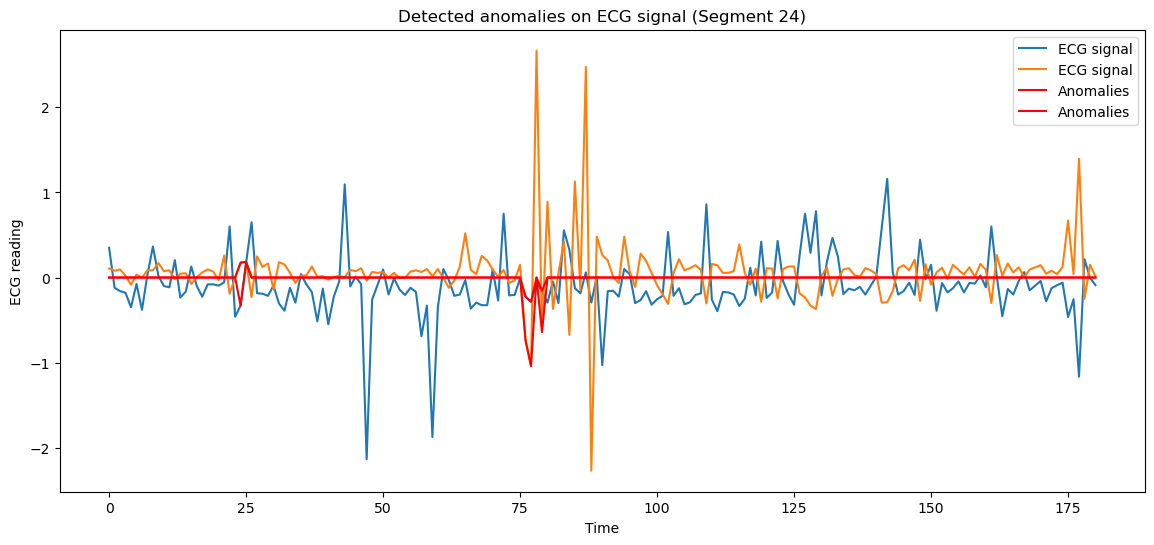

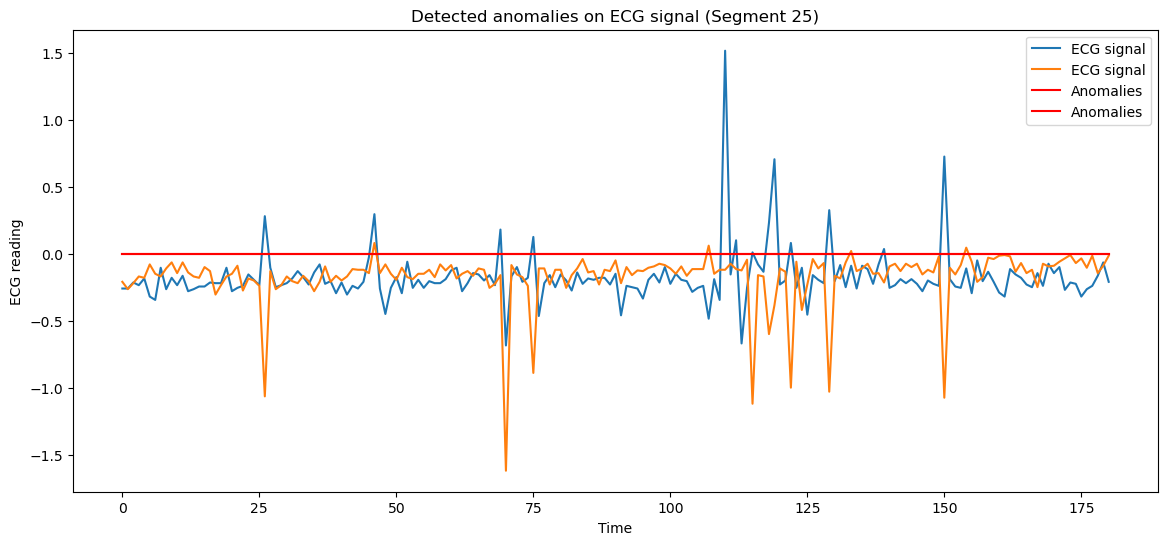

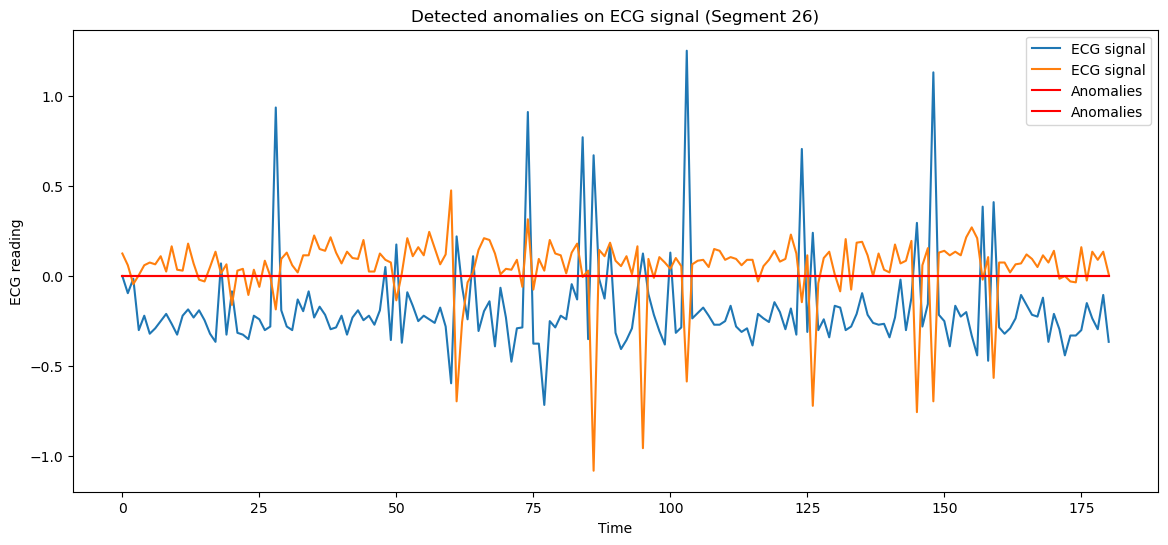

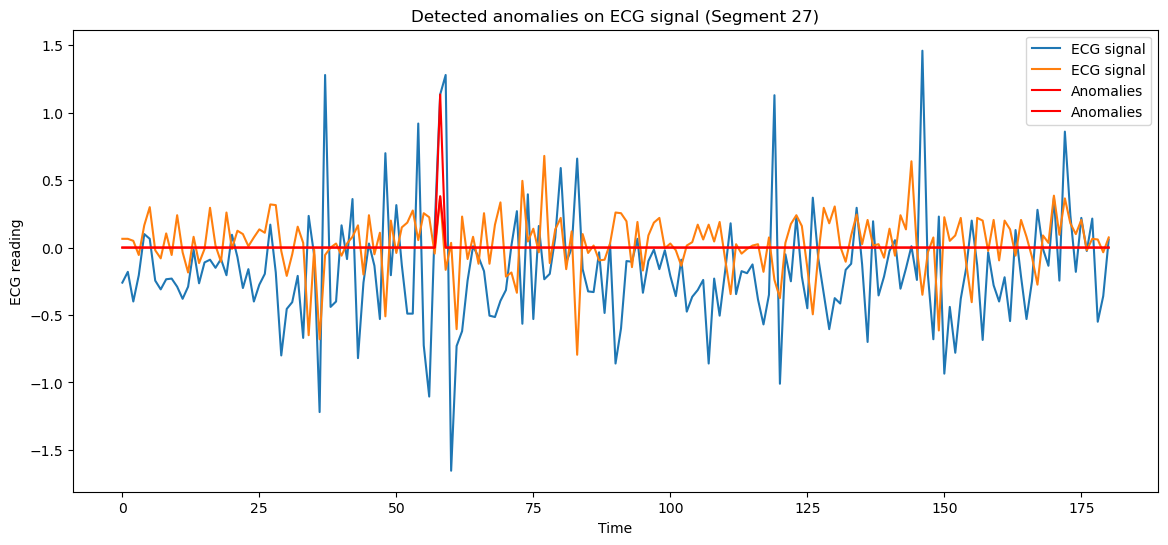

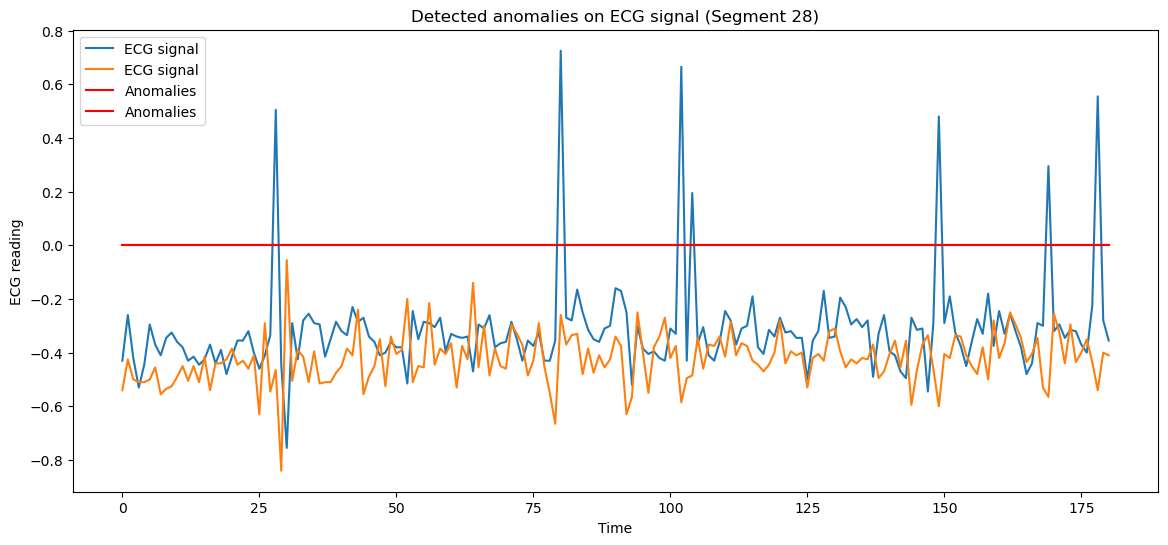

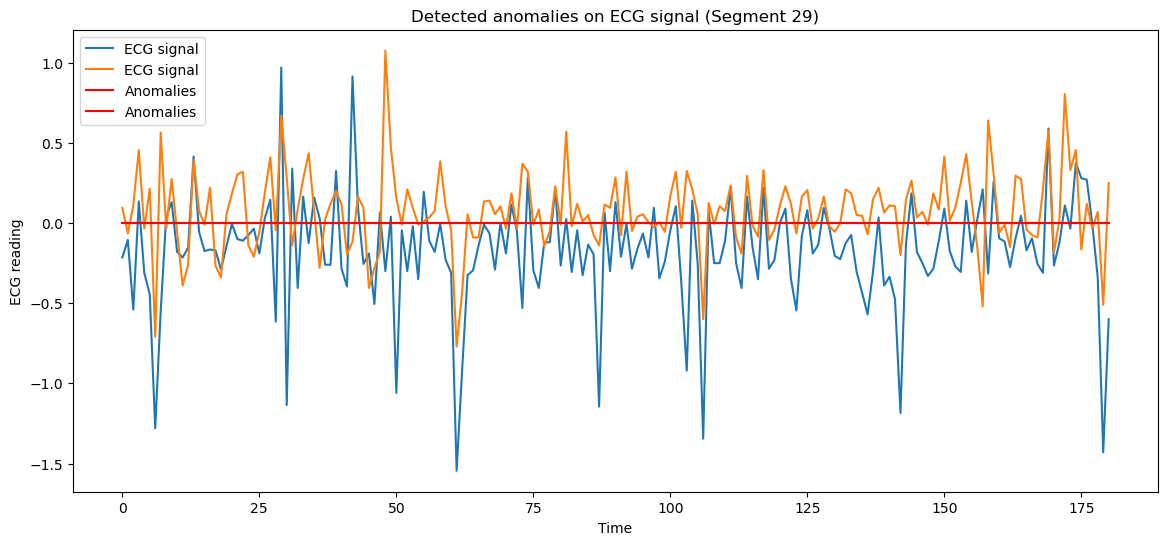

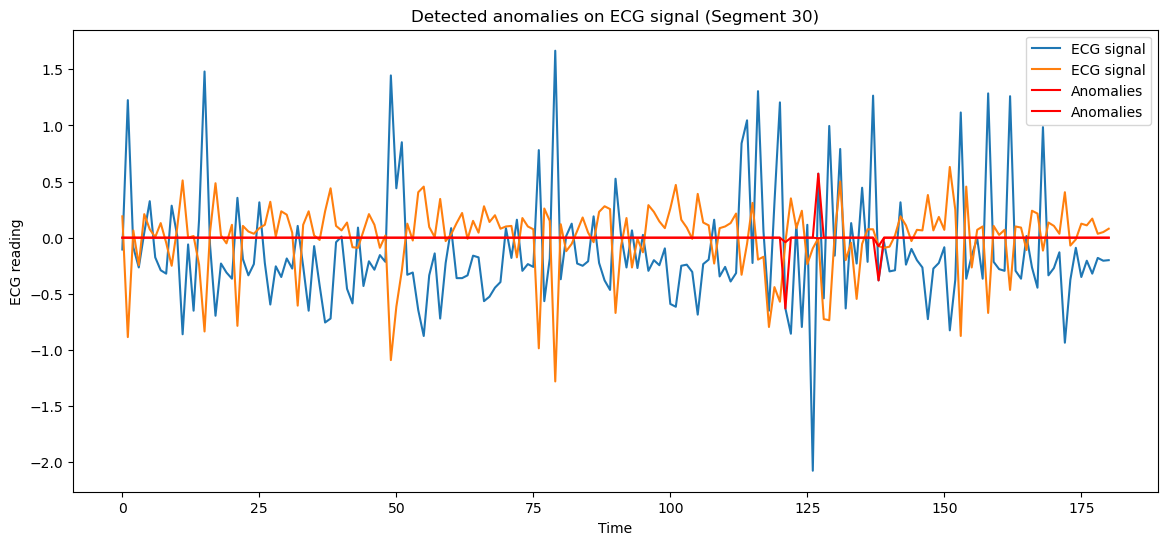

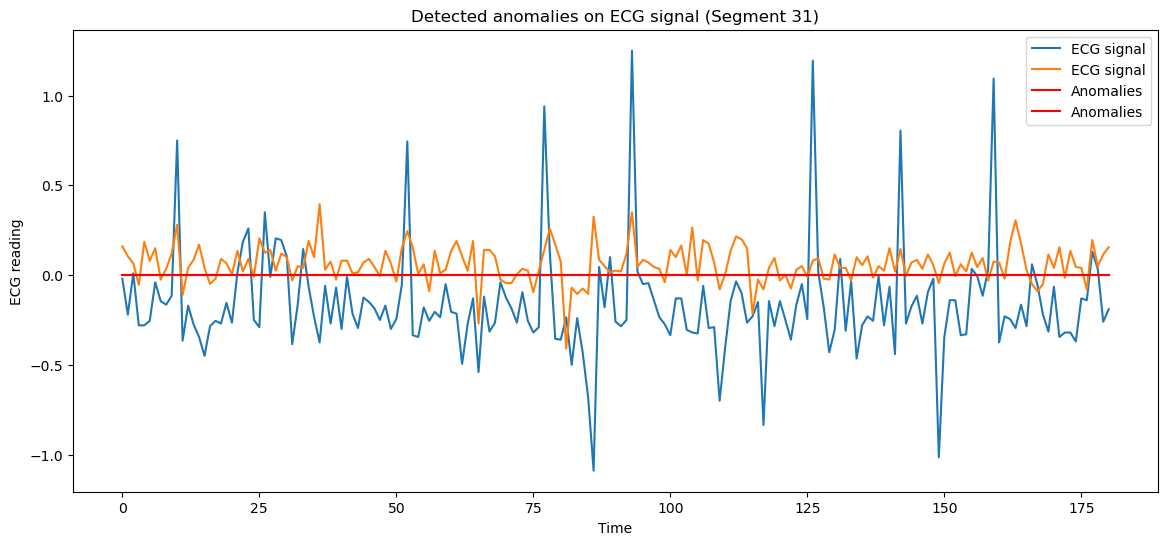

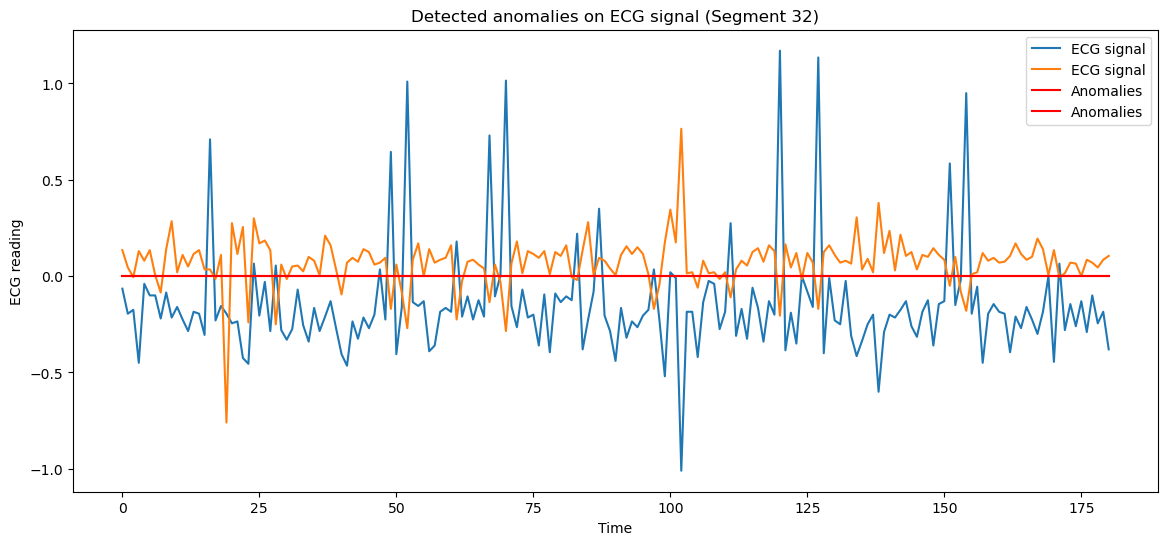

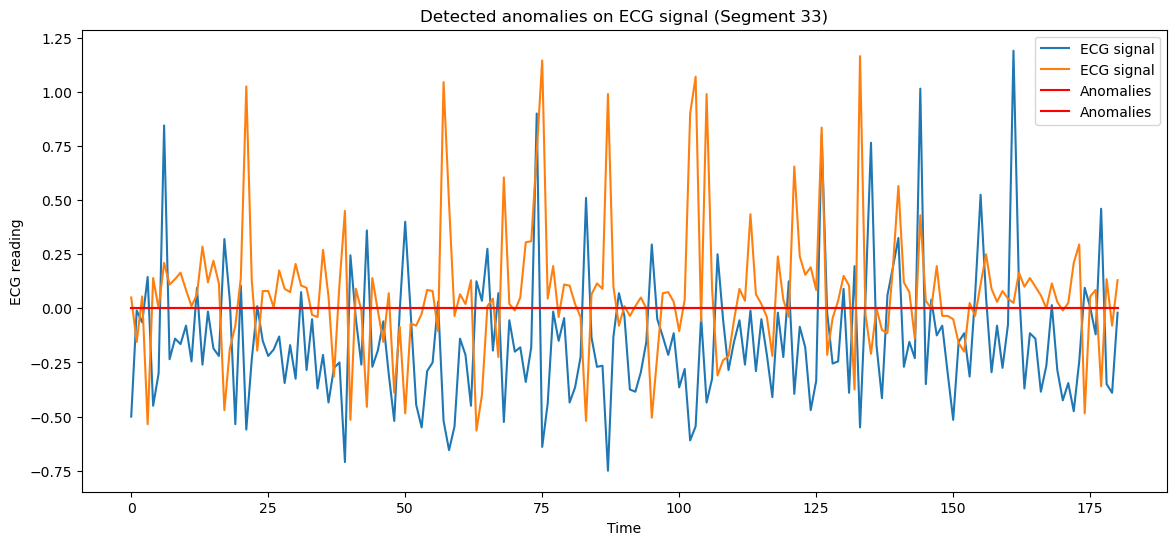

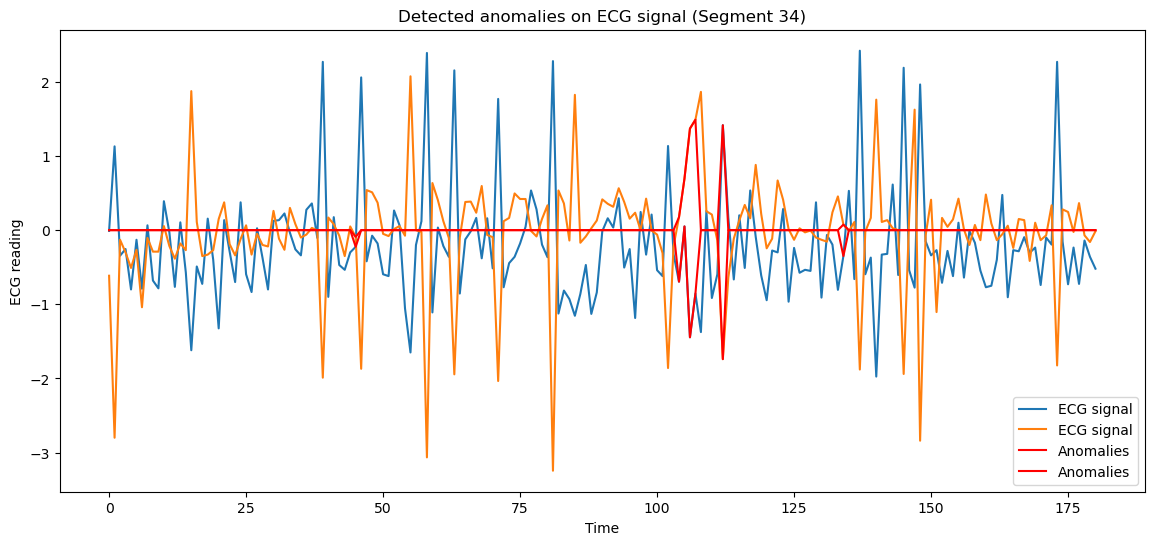

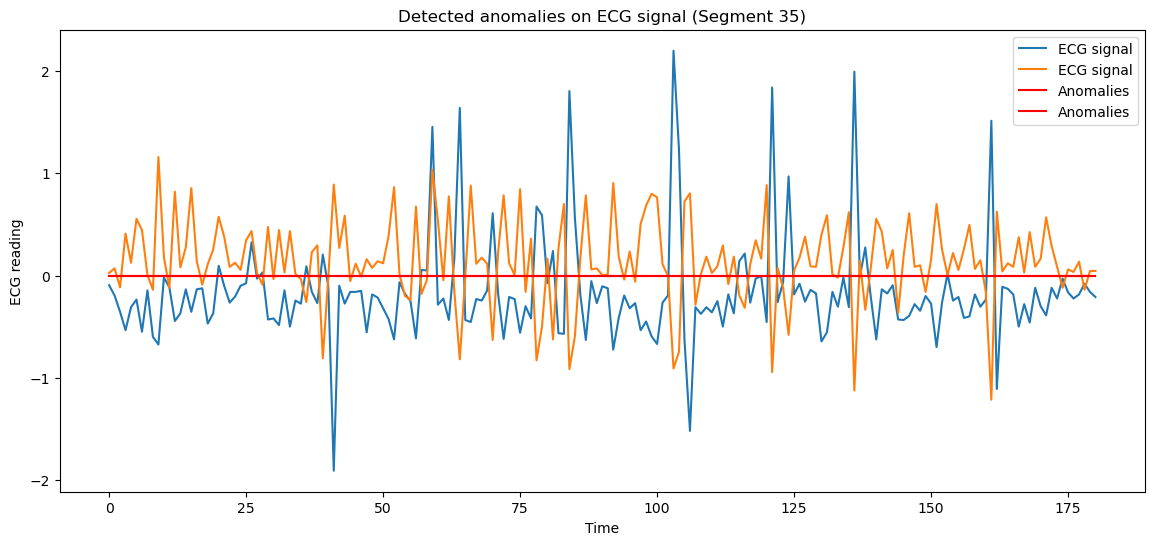

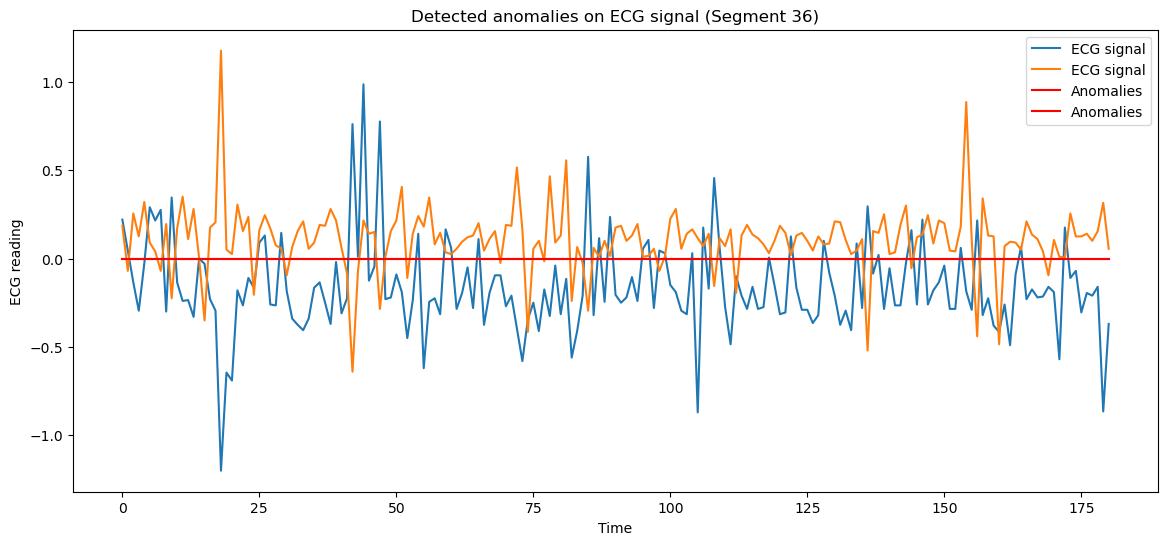

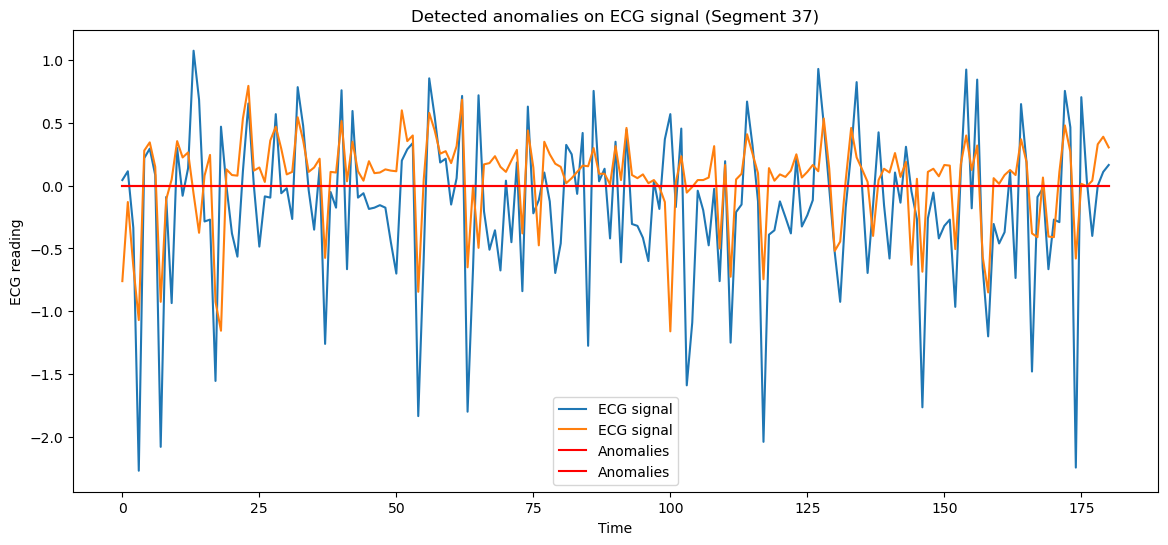

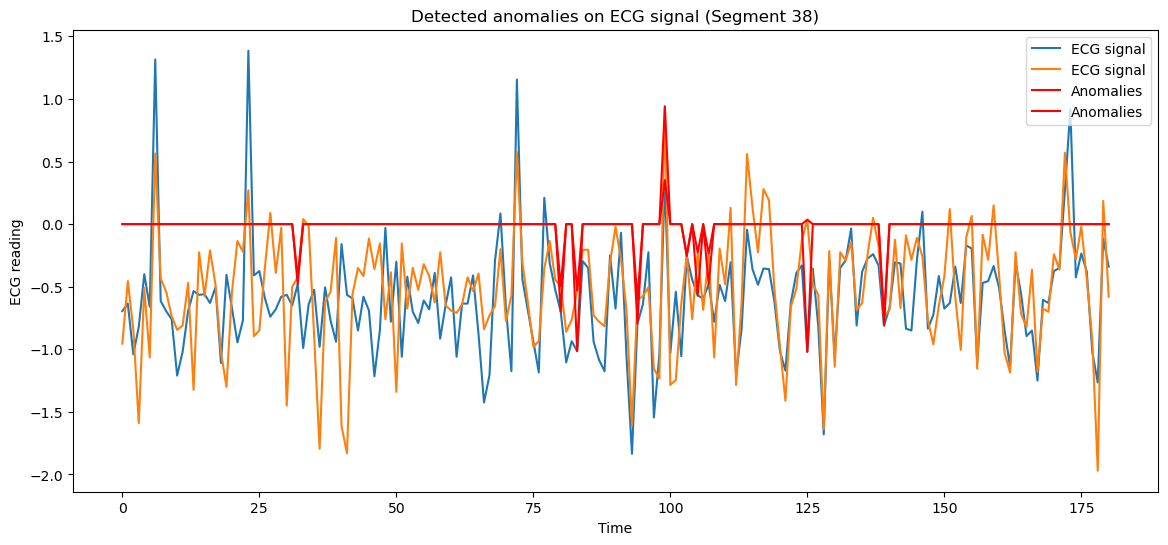

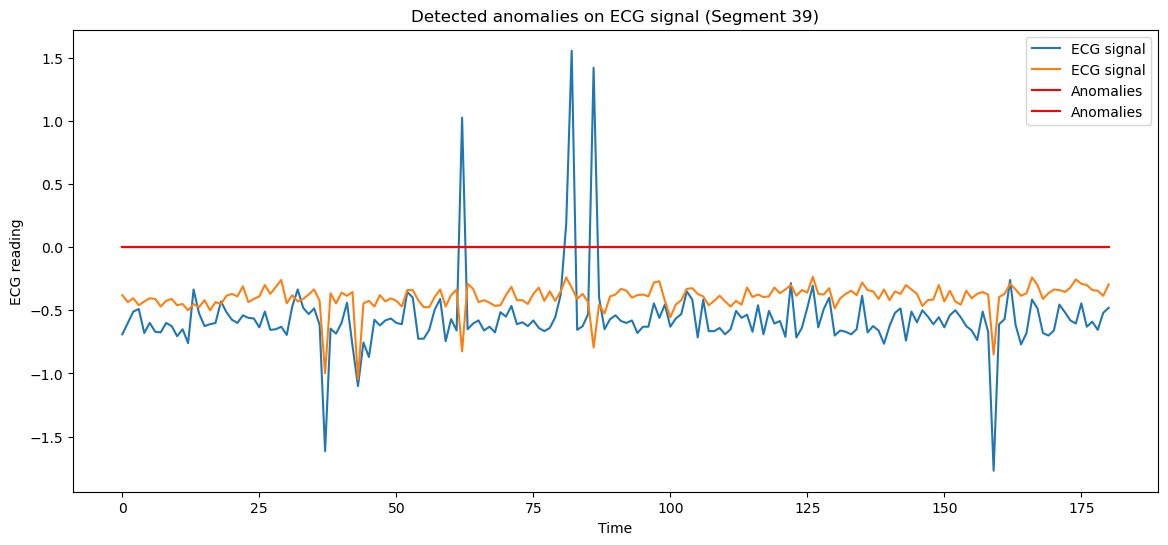

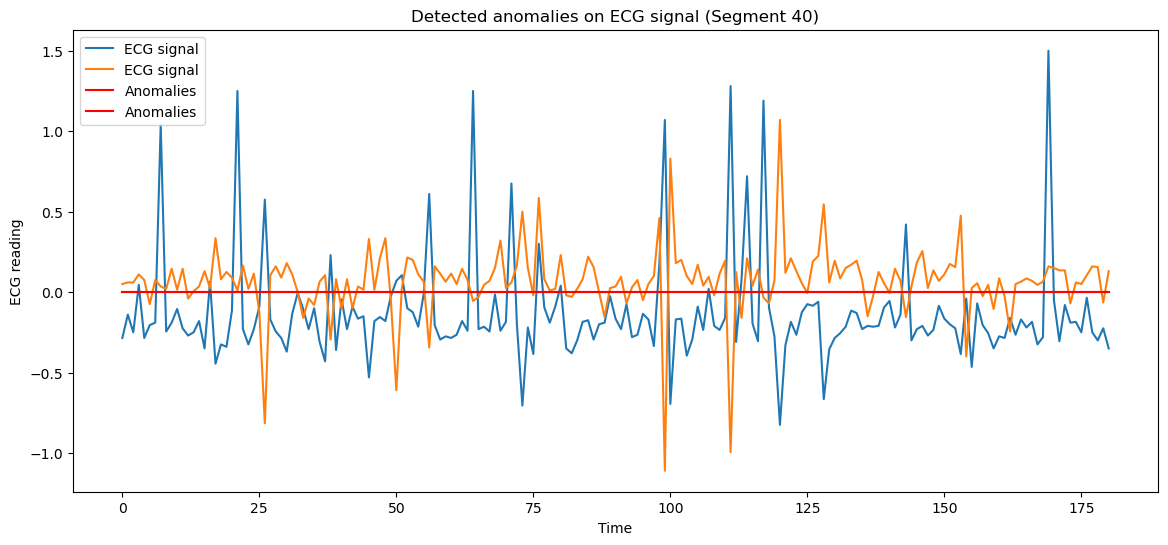

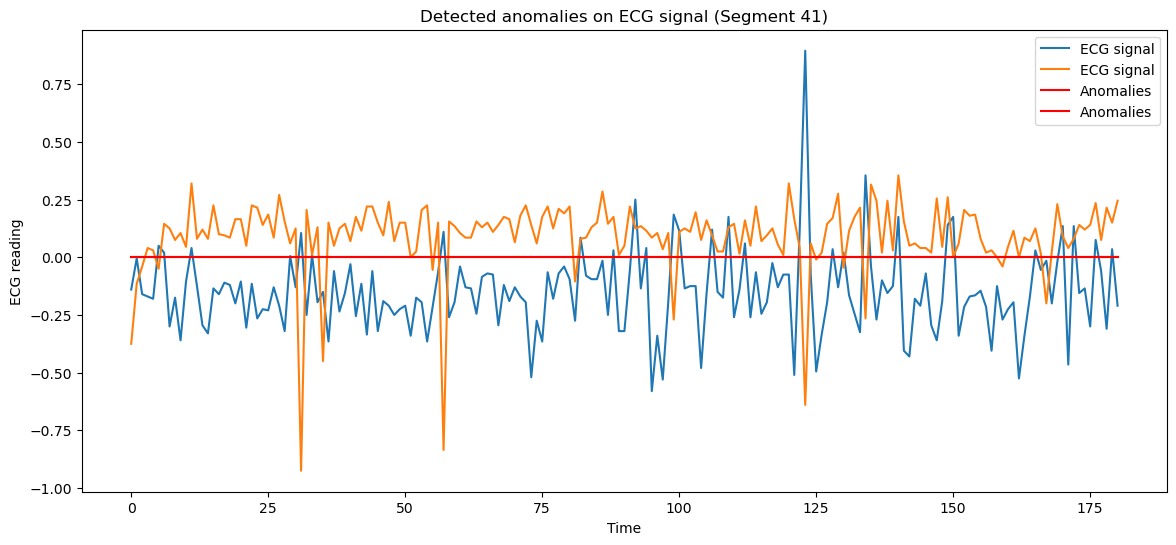

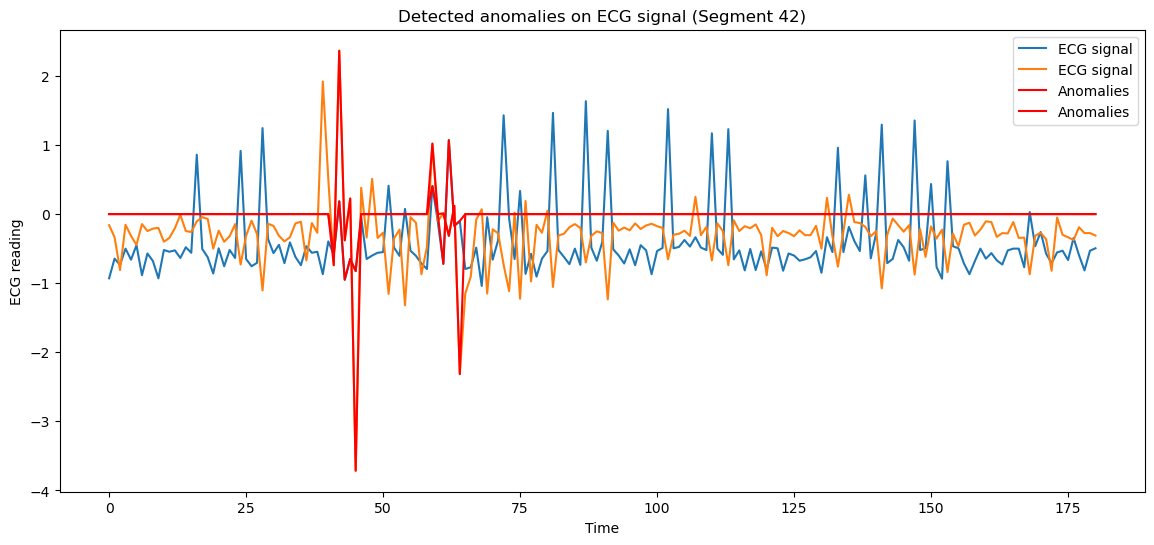

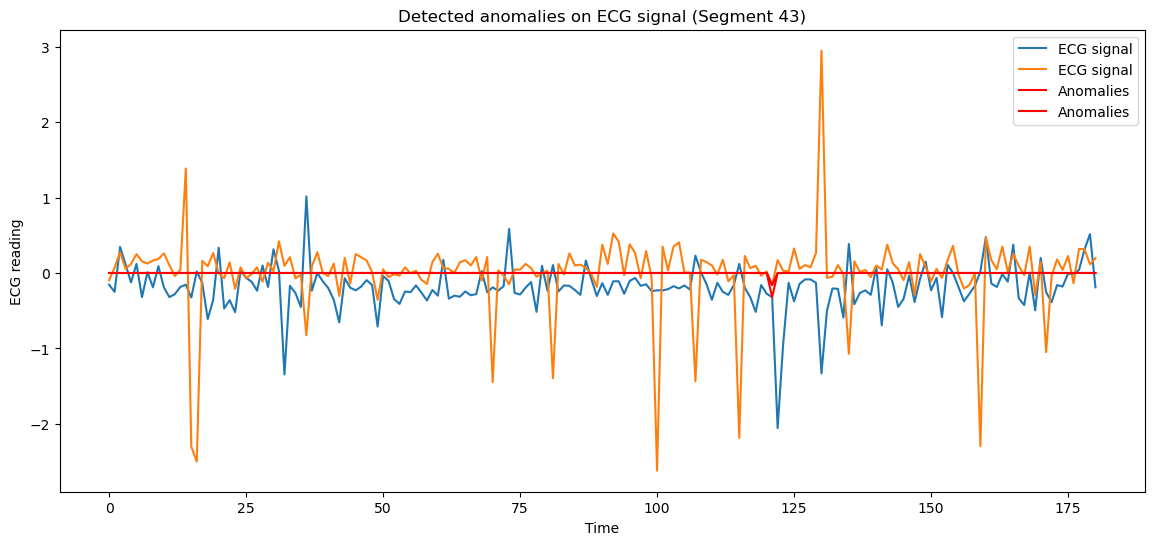

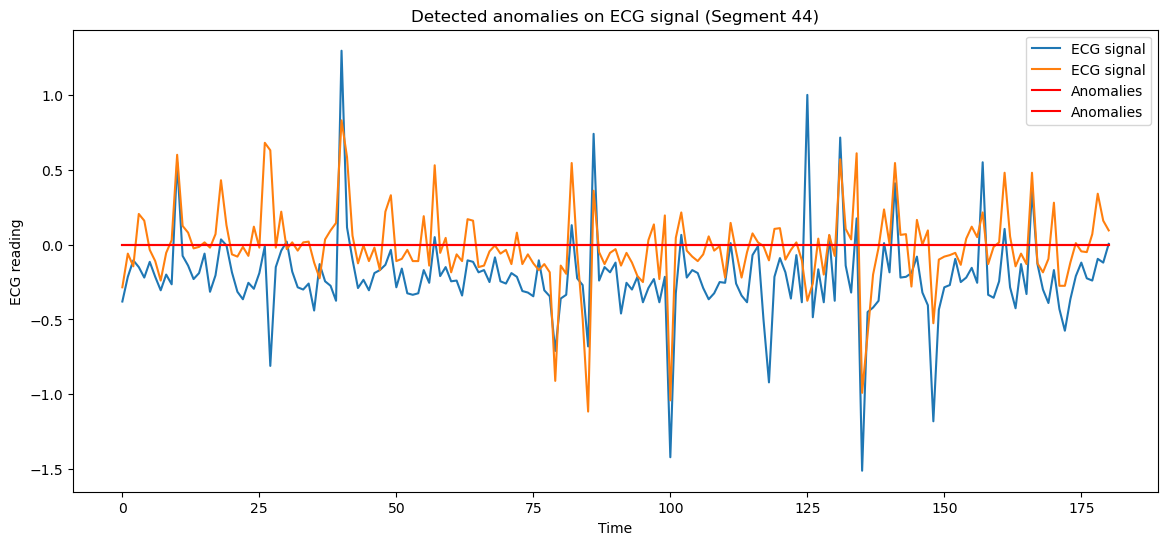

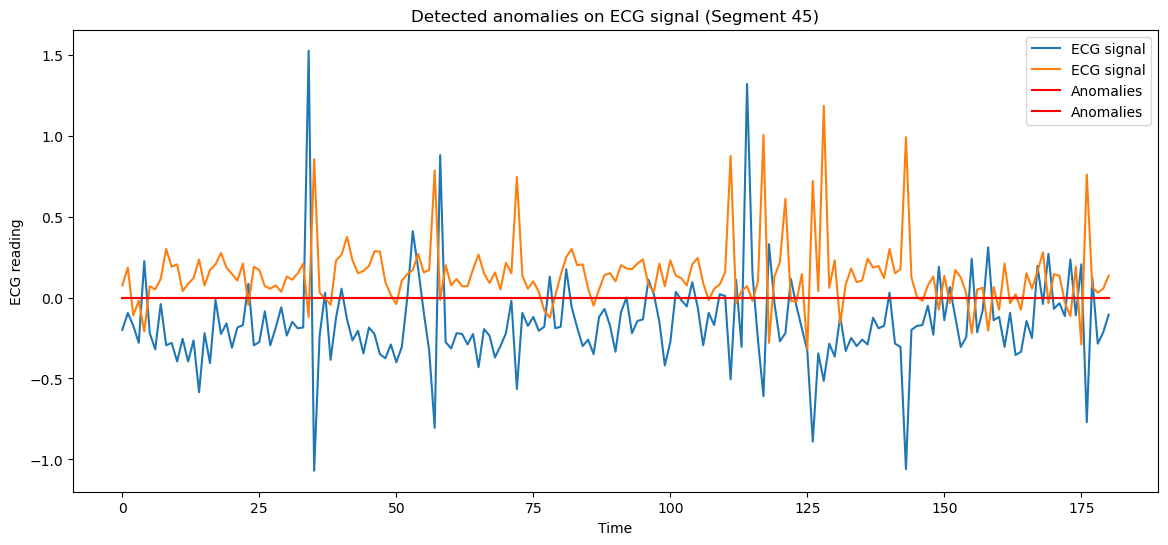

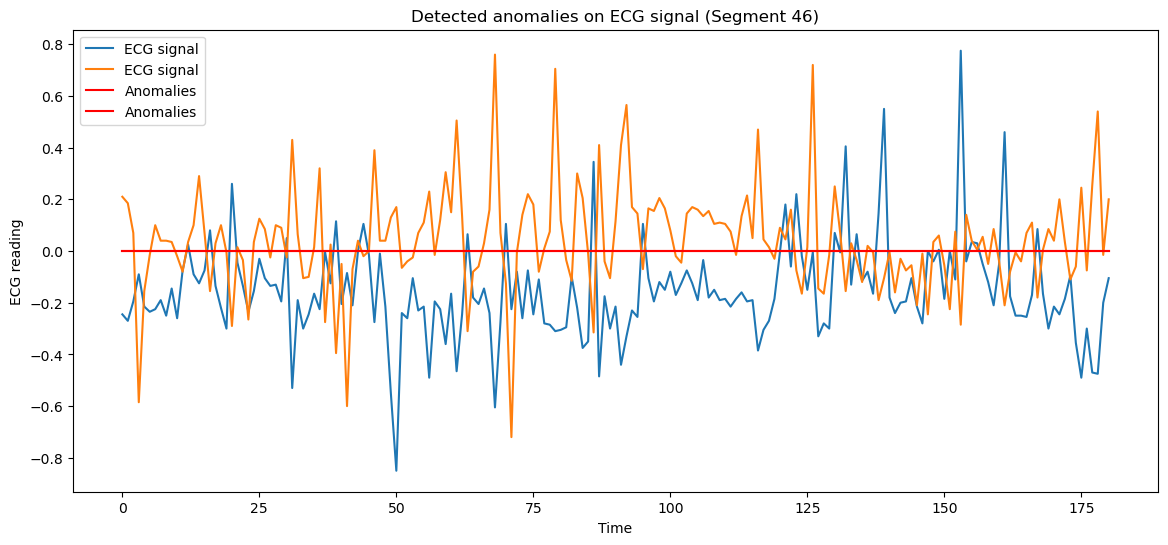

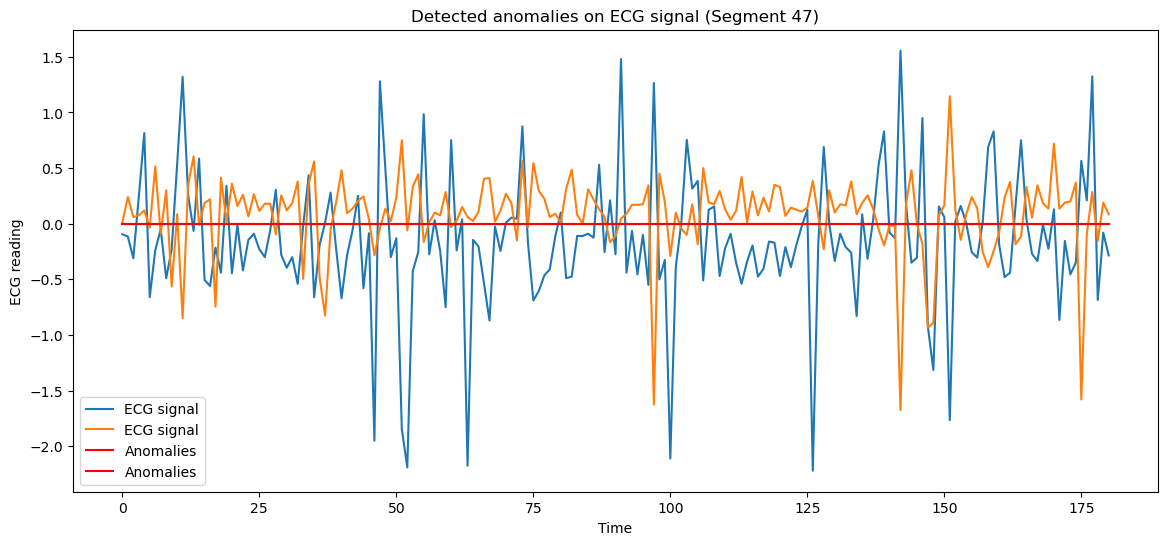

TypeError: '<' not supported between instances of 'int' and 'NoneType'

In [18]:
# Get the total number of data points
total_data_points = data.shape[0]

# Define the number of segments
segments = 48

# Calculate the number of data points per segment
data_points_per_segment = total_data_points // segments

for i in range(segments):
    start = i * data_points_per_segment
    end = start + data_points_per_segment if i != segments - 1 else None
    
    # Define anomaly data for the current segment
    anomaly_data_segment = np.zeros_like(data[start:end])
    anomalies_segment_indices = anomalies[(anomalies >= start) & (anomalies < end)] - start
    anomaly_data_segment[anomalies_segment_indices] = data[start:end][anomalies_segment_indices]

    # Plot the data for the current segment
    plt.figure(figsize=(14, 6))
    plt.plot(data[start:end, 0], label='ECG signal')
    plt.plot(anomaly_data_segment[:, 0], label='Anomalies', color='r')  # plot anomalies in red
    plt.xlabel('Time')
    plt.ylabel('ECG reading')
    plt.title(f"Detected anomalies on ECG signal (Segment {i+1})")
    plt.legend()
    plt.show()



# Confusion Matrix